In [1]:
# in JupyterHub, plot difference in DT across globe between VIIRS and L3S
# HealPix
# once you can get geographic plots to work, everything else is just changing what you want to plot

In [2]:
import xarray
import numpy as np
import pandas
import h5py
import datetime
from ulmo.utils import image_utils
from ulmo.plotting import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import os
import healpy as hp
# os.path.expanduser("~")

In [3]:
# read in 2012 h5 file

analysis_table = pandas.read_parquet('/home/jovyan/SST_L3S_VIIRS_2012.parquet')

file_path = '/home/jovyan/L3S_VIIRS144_2012_preproc.h5'
with h5py.File(file_path, 'r') as h5_file:
    h5_extractions = h5_file['valid']

In [4]:
analysis_table.columns[[20,21]]

Index(['lat', 'lon'], dtype='object')

In [5]:
analysis_table[['VIIRS_datetime', 'datetime']]

,VIIRS_datetime,datetime
0,2012-02-01 00:10:00,2012-01-31 13:42:26
1,2012-02-01 00:10:00,2012-01-31 13:44:47
2,2012-02-01 00:10:00,2012-01-31 13:49:19
3,2012-02-01 00:10:00,2012-01-31 13:46:48
4,2012-02-01 00:10:00,2012-01-31 13:44:00
...,...,...
293937,2012-12-31 23:20:00,2012-12-31 04:04:45
293938,2012-12-31 23:20:00,2012-12-31 03:48:18
293939,2012-12-31 23:20:00,2012-12-31 03:47:34
293940,2012-12-31 23:20:00,2012-12-31 03:46:52


In [6]:
file_path = '/home/jovyan/L3S_VIIRS144_2012_preproc.h5'

In [7]:
with h5py.File(file_path, "r") as h5:
    data = h5['valid'][:]
    metadata = h5['valid_metadata'][:]
        
data1 = data[0]
metadata1 = metadata[0]

viirs_dt = float(metadata1[8])
dt = float(metadata1[35])
diff_dt = viirs_dt - dt

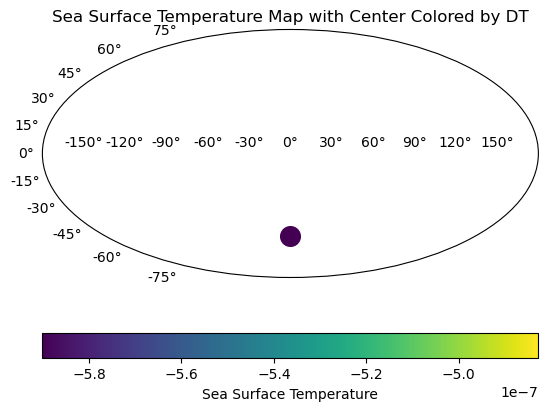

In [30]:
flat_sst_data = data1
flat_dt_data = diff_dt

nside = 8
npix = hp.nside2npix(nside)

hp_map = np.zeros(npix)
for i in range(npix):
    hp_map[i] = np.mean(flat_sst_data[i * (4096 // npix):(i + 1) * (4096 // npix)])

lon, lat = hp.pix2ang(nside, np.arange(npix), lonlat=True)

center_pixel_index = hp.ang2pix(nside, np.pi / 2 - np.radians(0), np.radians(0))
fig, ax = plt.subplots(subplot_kw={'projection': 'mollweide'})
im = ax.scatter(lon, lat, c=hp_map, cmap='viridis', s=10)
ax.scatter(lon[center_pixel_index], lat[center_pixel_index], c=flat_dt_data, cmap='viridis', s=200, linewidth=1, zorder=10)
ax.set_title('Sea Surface Temperature Map with Center Colored by DT')
cbar = plt.colorbar(im, ax=ax, orientation='horizontal')
cbar.set_label('Sea Surface Temperature')
plt.show()

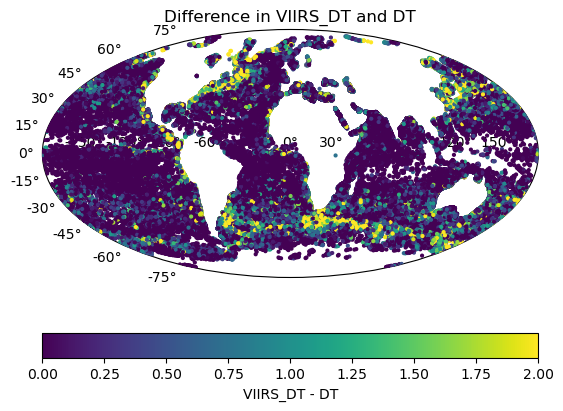

In [42]:
nside = 8
npix = hp.nside2npix(nside)

cutout_indices = metadata[:, [8, 20, 21, 35]]
num_cutouts = len(cutout_indices)

center_lat_values = np.zeros(num_cutouts)
center_lon_values = np.zeros(num_cutouts)
dt_values = np.zeros(num_cutouts)

for i in range(num_cutouts):
    viirs_dt = float(cutout_indices[i, 0])
    lat = float(cutout_indices[i, 1])
    lon = float(cutout_indices[i, 2])
    dt = float(cutout_indices[i, 3])

    center_lat_values[i] = lat
    center_lon_values[i] = lon

    dt_values[i] = viirs_dt - dt

# Calculate the Healpy map using your sea surface temperature data (replace flat_sst_data with your data)
hp_map = np.zeros(npix)
for i in range(npix):
    hp_map[i] = np.mean(dt_values[i * (4096 // npix):(i + 1) * (4096 // npix)])  # Adjust how the grid is averaged

# Plot the Healpy map and add dots at each array's value of DT with center latitude and longitude from metadata
fig, ax = plt.subplots(subplot_kw={'projection': 'mollweide'})
# Replace hp_map with your calculated Healpy map
# im = ax.scatter(lon, lat, c=hp_map, cmap='viridis', s=10)
im = ax.scatter(np.radians(center_lon_values), np.radians(center_lat_values), c=dt_values, cmap='viridis', s=4, linewidth=1, zorder=10, vmin = 0, vmax = 2)
#hp.cartview(hp_map, cmap='viridis', lonra=[-180, 180], latra=[-90, 90], cbar=False, hold=True)
ax.set_title('Difference in VIIRS_DT and DT')
cbar = plt.colorbar(im, ax=ax, orientation='horizontal')
cbar.set_label('VIIRS_DT - DT')

plt.show()

In [5]:
# rest of this code does not work


with h5py.File(file_path, "r") as h5:
    metadata = h5["valid_metadata"][:]  # Replace "metadata" with the dataset name containing metadata

# Extract the 8th, 20th, 21st, and 35th indices for each cutout
cutout_indices = metadata[:, [8, 20, 21, 35]]

In [ ]:
# Loop through each cutout entry and plot the subarray area centered at lat, lon
nside = 64  # Adjust the nside to control the resolution of the map
for i in range(len(cutout_indices)):
    viirs_dt = float(cutout_indices[i, 0])
    lat = float(cutout_indices[i, 1])
    lon = float(cutout_indices[i, 2])
    dt = float(cutout_indices[i, 3])
    
    healpix_map = np.zeros(hp.nside2npix(nside))
    pix_index = hp.pixelfunc.ang2pix(nside, np.pi / 2 - np.radians(lat), np.radians(lon))
    healpix_map[pix_index] = viirs_dt - dt  
    hp.mollview(healpix_map, title=f"Cutout {i+1}", unit="Difference", min=-2, max=2, cmap='coolwarm')
    plt.close()

In [38]:
plt.show()

0.99853515625